<a href="https://colab.research.google.com/github/Baah134/Baah134/blob/main/SER_CARINE/Paper_7_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import cv2  # For image resizing
from tqdm import tqdm

# --- 1. SETUP & FILTERING (Modified from your snippet) ---

emodb_path = "/content/drive/MyDrive/DeepLearning/External/EMoDB/"
# Ensure you point to the 'wav' folder inside EMO-DB if files are nested
# If your files are directly in 'emodb', this works.
# Usually EMO-DB has a 'wav' folder.
if os.path.exists(os.path.join(emodb_path, 'wav')):
    emodb_directory_list = os.listdir(os.path.join(emodb_path, 'wav'))
    full_path_root = os.path.join(emodb_path, 'wav')
else:
    emodb_directory_list = os.listdir(emodb_path)
    full_path_root = emodb_path

file_emotion = []
file_path = []
speaker_id = []

# Filter: The paper explicitly only used these 4 emotions
TARGET_EMOTIONS = ['Angry', 'Happiness', 'Sadness', 'Neutral']

for file in emodb_directory_list:
    # EMO-DB format: positions 0-1 are speaker ID, position 5 is emotion
    if not file.endswith('.wav'): continue

    # Extract Emotion Code
    code = file[5]
    label = None
    if code == 'W': label = 'Angry'
    elif code == 'F': label = 'Happiness'
    elif code == 'T': label = 'Sadness'
    elif code == 'N': label = 'Neutral'

    # Extract Speaker ID (First 2 chars)
    sid = file[0:2]

    # Only append if it's one of the target emotions
    if label in TARGET_EMOTIONS:
        file_path.append(os.path.join(full_path_root, file))
        file_emotion.append(label)
        speaker_id.append(sid)

# Create DataFrame
EMoDB_df = pd.DataFrame({
    'Path': file_path,
    'Emotions': file_emotion,
    'Speaker': speaker_id
})

print("Data Loaded:")
print(EMoDB_df['Emotions'].value_counts())
print(f"Total files after filtering: {len(EMoDB_df)}")

# --- 2. FEATURE EXTRACTION PIPELINE (Faithful Replication) ---

def extract_vit_features(file_path, sr=16000, duration=3, target_size=(224, 224)):
    """
    Implements the Paper's preprocessing:
    Audio -> RMS Norm -> Padding -> MelSpectrogram -> Resize -> 3 Channel
    """
    try:
        # 1. Load Audio
        y, _ = librosa.load(file_path, sr=sr)

        # 2. RMS Normalization
        # Calculate RMS and normalize the signal
        rms = np.sqrt(np.mean(y**2))
        # Avoid division by zero
        if rms > 0:
            y = y / rms

        # 3. Fix Length (Padding/Truncating) [cite: 182, 183]
        # Paper implies padding to fixed length.
        # 3 seconds * 16000Hz = 48000 samples is standard for EMO-DB.
        target_length = sr * duration
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), 'constant')
        else:
            y = y[:target_length]

        # 4. Generate Mel Spectrogram [cite: 144, 210]
        # Paper doesn't specify N_FFT, using standard defaults for speech
        mel_spect = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512
        )

        # Convert to Decibels (Log Scale)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

        # 5. Image Resizing [cite: 175, 209]
        # Resize to square image (ViT requirement)
        # Normalizing to 0-255 range for image processing
        norm_spec = (mel_spect_db - mel_spect_db.min()) / (mel_spect_db.max() - mel_spect_db.min())
        norm_spec = (norm_spec * 255).astype(np.uint8)

        # Resize to target (e.g., 224x224)
        resized_spec = cv2.resize(norm_spec, target_size)

        # 6. Stack to 3 Channels (RGB)
        # Standard ViTs expect 3 channels. Even custom ones often use this structure.
        img_rgb = cv2.merge([resized_spec, resized_spec, resized_spec])

        # Normalize to [0, 1] range for Neural Network
        img_rgb = img_rgb / 255.0

        return img_rgb

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# --- 3. RUN EXTRACTION ---

print("\nStarting Feature Extraction (ViT Pipeline)...")

X = []
y = []
speakers = []

# Use tqdm for progress bar
for index, row in tqdm(EMoDB_df.iterrows(), total=EMoDB_df.shape[0]):
    feature = extract_vit_features(row['Path'])

    if feature is not None:
        X.append(feature)
        y.append(row['Emotions'])
        speakers.append(row['Speaker'])

# Convert to Numpy Arrays
X = np.array(X)
y = pd.get_dummies(y).values # One-hot encode emotions
speakers = np.array(speakers)

print(f"\nExtraction Complete.")
print(f"Input Shape (X): {X.shape}") # Should be (N, 224, 224, 3)
print(f"Labels Shape (y): {y.shape}")

# Save to disk for the next step (Training)
# np.save("X_vit_emodb.npy", X)
# np.save("y_vit_emodb.npy", y)
# np.save("speakers_vit_emodb.npy", speakers)

Data Loaded:
Emotions
Angry        127
Neutral       79
Happiness     71
Sadness       62
Name: count, dtype: int64
Total files after filtering: 339

Starting Feature Extraction (ViT Pipeline)...


100%|██████████| 339/339 [00:40<00:00,  8.47it/s]



Extraction Complete.
Input Shape (X): (339, 224, 224, 3)
Labels Shape (y): (339, 4)


In [ ]:
output_dir = "/content/vit_emodb/"

# 2. Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# 3. Save the arrays
print(f"Saving artifacts to {output_dir}...")

# Save Features (Images)
np.save(os.path.join(output_dir, "X.npy"), X)

# Save Labels (One-Hot Encoded)
np.save(os.path.join(output_dir, "y.npy"), y)

# Save Speaker IDs (CRITICAL for your Generalization Hypothesis)
np.save(os.path.join(output_dir, "speakers.npy"), speakers)

print("Saved successfully.")
print(f"Feature Size: {os.path.getsize(os.path.join(output_dir, 'X.npy')) / 1e6:.2f} MB")

Saving artifacts to /content/vit_emodb/...
Saved successfully.
Feature Size: 408.23 MB


In [ ]:
!zip -r vit_emodb.zip vit_emodb/

  adding: vit_emodb/ (stored 0%)
  adding: vit_emodb/y.npy (deflated 78%)
  adding: vit_emodb/X.npy (deflated 94%)
  adding: vit_emodb/speakers.npy (deflated 88%)


In [3]:
!unzip -q vit_emodb.zip -d ./

# **VERIFICATION**

Loading ViT features...
Training Shape: (271, 224, 224, 3)
Testing Shape: (68, 224, 224, 3)


Model: "Kumar_ViT_Replication"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_1 (Patches) │ (None, None,      │          0 │ input_layer_1[0]… │
│                     │ 18816)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_1     │ (None, 8, 64)     │  1,204,800 │ patches_1[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 64)     │        128 │ patch_encoder_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 64)     │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 8, 64)     │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 64)     │        128 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 8, 128)    │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 8, 128)    │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 8, 64)     │      8,256 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 8, 64)     │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 8, 64)     │          0 │ dropout_27[0][0], │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 64)     │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 64)     │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 8, 64)     │          0 │ multi_head_atten… │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 64)     │        128 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 8, 128)    │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 8, 128)    │          0 │ dense_21[0][0]  

 Total params: 1,870,788 (7.14 MB)

 Trainable params: 1,870,788 (7.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3271 - loss: 1.8928 - val_accuracy: 0.1786 - val_loss: 1.5647
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.3399 - loss: 1.5488 - val_accuracy: 0.5000 - val_loss: 1.3557
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3799 - loss: 1.5779 - val_accuracy: 0.4643 - val_loss: 1.2801
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3678 - loss: 1.3718 - val_accuracy: 0.5714 - val_loss: 1.1915
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3850 - loss: 1.4148 - val_accuracy: 0.5714 - val_loss: 1.1661
Epoch 6/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5060 - loss: 1.1824 - val_accuracy: 0.6071 - val_loss: 1.1046
Epoch 7/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5091 - loss: 1.1934 - val_accuracy: 0.5714 - val_loss: 1.0817
Epoch 8/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6052 - loss: 0.9997 - val_accuracy: 0.6071 - v

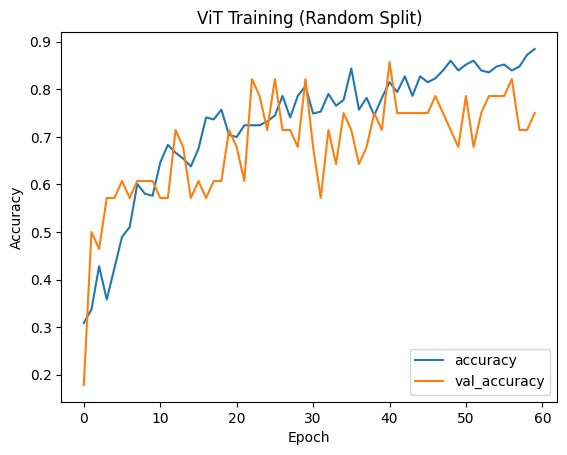

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION (From Paper) ---
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4          # Anger, Happiness, Sadness, Neutral [cite: 185]
NUM_PATCHES = 8          # "The image was divided into eight patches"
PROJECTION_DIM = 64      # Embedding size for each patch (Custom "Lite" ViT)
NUM_HEADS = 4            # Number of attention heads
TRANSFORMER_LAYERS = 8   # "along with 8 transformer layers"
LEARNING_RATE = 0.0001    #
BATCH_SIZE = 16          #
EPOCHS = 60              # Paper shows ~30 epochs in Fig 5 [cite: 193]

# Path to your saved features
DATA_PATH = "/content/vit_emodb/"

# --- 2. DATA LOADING ---
def load_data():
    print("Loading ViT features...")
    X = np.load(os.path.join(DATA_PATH, "X.npy"))
    y = np.load(os.path.join(DATA_PATH, "y.npy"))
    # We ignore speakers.npy for this specific "Random Split" verification step
    return X, y

# --- 3. CUSTOM VIT ARCHITECTURE ---

class Patches(layers.Layer):
    """
    Custom layer to slice the spectrogram into 8 vertical strips.
    """
    def __init__(self, patch_width, **kwargs):
        super().__init__(**kwargs)
        self.patch_width = patch_width

    def call(self, images):
        # images shape: (BATCH, 224, 224, 3)
        # We want to extract patches.
        # Since we want 8 vertical strips, patch height = 224, patch width = 28 (224/8)
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, 224, self.patch_width, 1],
            strides=[1, 224, self.patch_width, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # Output shape: (BATCH, 1, 8, 224*28*3) -> Flatten patch dimension
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    """
    Projects the patches to a dense vector (64 dim) and adds position info.
    """
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    inputs = layers.Input(shape=INPUT_SHAPE)

    # 1. Create Patches
    # 224 width / 8 patches = 28 pixels per patch width
    patch_width = 28
    patches = Patches(patch_width)(inputs)

    # 2. Encode Patches (Linear Projection + Position Embedding)
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    # 3. Transformer Encoder Blocks (Loop 8 times)
    for _ in range(TRANSFORMER_LAYERS):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-Head Attention
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        # Skip Connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = layers.Dense(PROJECTION_DIM * 2, activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(0.1)(x3)
        x3 = layers.Dense(PROJECTION_DIM)(x3)
        x3 = layers.Dropout(0.1)(x3)
        # Skip Connection 2
        encoded_patches = layers.Add()([x3, x2])

    # 4. Classification Head
    # Global Average Pooling treats the 8 patches as a sequence and averages them
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)

    features = layers.Dropout(0.5)(representation)
    # Output Layer (4 Classes)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Kumar_ViT_Replication")
    return model

# --- 4. EXPERIMENT EXECUTION ---

# Load Data
X, y = load_data()

# Split Data (Random Split 80/20) [cite: 181]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

# Build Model
vit_model = create_vit_classifier()
vit_model.summary()

# Compile
optimizer = keras.optimizers.Adamax(learning_rate=LEARNING_RATE) # Adamax is often more stable for ViT than vanilla Adam
vit_model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train
history = vit_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1, # Use part of train for validation during epochs
    shuffle=True
)

# Evaluate
print("\n--- Final Evaluation on Random Split ---")
loss, accuracy = vit_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the model
vit_model.save(os.path.join(DATA_PATH, "vit_emodb_random_split.keras"))

# Plot History
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('ViT Training (Random Split)')
plt.show()

Loading ViT features...
Splitting data... Test Speakers: ['15', '16']
Training Set: 266 samples (Speakers: ['03' '08' '09' '10' '11' '12' '13' '14'])
Test Set:     73 samples (Speakers: ['15' '16'])

Starting Training on Strict Speaker Split...
Epoch 1/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.2580 - loss: 1.8742 - val_accuracy: 0.3836 - val_loss: 1.2449
Epoch 2/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2566 - loss: 1.7390 - val_accuracy: 0.4521 - val_loss: 1.1499
Epoch 3/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3589 - loss: 1.4982 - val_accuracy: 0.6438 - val_loss: 1.0392
Epoch 4/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4448 - loss: 1.3149 - val_accuracy: 0.6712 - val_loss: 0.9710
Epoch 5/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4696 - loss: 1.2124 - val_accuracy: 0.6575 - val_loss: 0.8919
Epoch 6/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4961 - loss: 1.1165 - val_accuracy: 0.6849 - val_loss: 0

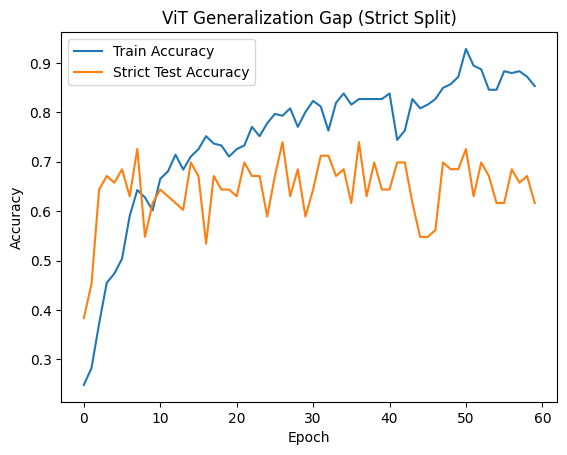

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. CONFIGURATION ---
# Path to your saved features
DATA_PATH = "/content/vit_emodb/"

# Hyperparameters (Must match the Replication exactly)
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4
NUM_PATCHES = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_LAYERS = 8
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
EPOCHS = 60

# --- 2. DATA LOADING & STRICT SPLIT ---
def load_and_split_data():
    print("Loading ViT features...")
    X = np.load(os.path.join(DATA_PATH, "X.npy"))
    y = np.load(os.path.join(DATA_PATH, "y.npy"))
    speakers = np.load(os.path.join(DATA_PATH, "speakers.npy"))

    # Define Test Speakers (Strictly Unseen)
    # EMO-DB Speakers: 03, 08, 09, 10, 11, 12, 13, 14, 15, 16
    test_speaker_ids = ['15', '16']

    print(f"Splitting data... Test Speakers: {test_speaker_ids}")

    # Create Boolean Mask
    # Returns True if speaker is in test_set, False otherwise
    test_mask = np.isin(speakers, test_speaker_ids)

    # Apply Split
    X_train = X[~test_mask]
    y_train = y[~test_mask]

    X_test = X[test_mask]
    y_test = y[test_mask]

    print(f"Training Set: {X_train.shape[0]} samples (Speakers: {np.unique(speakers[~test_mask])})")
    print(f"Test Set:     {X_test.shape[0]} samples (Speakers: {np.unique(speakers[test_mask])})")

    return X_train, y_train, X_test, y_test

# --- 3. MODEL ARCHITECTURE (Exact Copy) ---
# We redefine classes here to ensure standalone execution

class Patches(layers.Layer):
    def __init__(self, patch_width, **kwargs):
        super().__init__(**kwargs)
        self.patch_width = patch_width

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, 224, self.patch_width, 1],
            strides=[1, 224, self.patch_width, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    inputs = layers.Input(shape=INPUT_SHAPE)
    patch_width = 28 # 224 / 8
    patches = Patches(patch_width)(inputs)
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    for _ in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(PROJECTION_DIM * 2, activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(0.1)(x3)
        x3 = layers.Dense(PROJECTION_DIM)(x3)
        x3 = layers.Dropout(0.1)(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    features = layers.Dropout(0.5)(representation)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(features)

    return keras.Model(inputs=inputs, outputs=outputs)

# --- 4. EXECUTION ---

# Load Strict Split
X_train, y_train, X_test, y_test = load_and_split_data()

# Build Model
model = create_vit_classifier()
optimizer = keras.optimizers.Adamax(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train
print("\nStarting Training on Strict Speaker Split...")
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test), # Use Test set as validation to monitor generalization gap
    shuffle=True
)

# Final Evaluation
print("\n--- Final Evaluation (Strict Speaker Split) ---")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Strict Split Accuracy: {accuracy * 100:.2f}%")

# Generate Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
emotions = ['Angry', 'Happiness', 'Sadness', 'Neutral'] # Alphabetical order usually, check your one-hot encoding

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=emotions))

# Save this specific model
model.save(os.path.join(DATA_PATH, "vit_emodb_strict_split.keras"))

# Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Strict Test Accuracy')
plt.title('ViT Generalization Gap (Strict Split)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()